<a id='top'></a>
# calwebb_detector2 with background exposures
---
**Author**: Jonathan Aguilar (jaguilar@stsci.edu) | **Latest Update**: 23 Oct 2023

In this notebook, we run `calwebb_image2` at the stage level using a custom-built association file to enable background subtraction.

* [Introduction](#intro)
* [Imports](#imports)
* [Convenience tools](#convenience_tools)
* [Collect Stage 1 products](#file_selection)
* [Run Stage 2](#image2)

<a id='intro'></a>
## Introduction

See [calwebb_image2-single_exposure.ipynb](calwebb_image2-single_exposure.ipynb) for a detailed description of the `calwebb_image2` pipeline stage. In this notebook, we include background subtraction by providing the `Image2Detector` class with an association file that tells it which exposures to use for constructing a composite background, and from which exposures that particular background should be removed. This association file can either be downloaded from MAST or constructed by hand. Custom association files allow the user to choose which background observations should be included.

<a id='imports'></a>
## Non-pipeline imports

In [1]:
import os
from collections import OrderedDict
from pathlib import Path

In [2]:
import numpy as np

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from astropy.io import fits

<a id='convenience_tools'></a>
## Convenience tools

Environment paths and functions that make life easier.

First, set up a local CRDS directory. When the pipeline pulls a reference file from CRDS for the first time, it will write a copy to this directory. All subsequent reads of the reference file will redirect to the local directory instead of sending the file again over the network.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/user_documentation/reference_files_crds.html#crds

In [4]:
os.environ['CRDS_PATH'] = '/Volumes/agdisk/crds/'
# os.environ['CRDS_PATH'] = ''
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

Advanced users - uncomment the cell below and specify the context if you have a specific combination of reference files you want to use

In [5]:
# os.environ['CRDS_CONTEXT'] = 'jwst_1140.pmap'

In [6]:
# some plot formatting
mpl.rcParams['image.origin'] = "lower"

In [7]:
# you may need to run this command twice for plots to pop up correctly
# %matplotlib auto
%matplotlib inline

### Logging configuration

The logging statements can be quite extensive, which can make a notebook cumbersome to read on Github in an executed state. To help the users, we're going to redirect the logging statements to log files stored in each step's output folder. That way you the notebook will be stripped down to the commands and diagnostic output, but the logging statements are preserved so users can compare them against the output in their own notebooks. 

In the cell below you'll find the template to the logging configuration file. The logging configuration file contains the path to the log file and the level of verbosity. At each step, we will call the `generate_log_file` function to create a config file, and pass that file to the step. The step will then generate a log file in the output directory.

In [8]:
cfg_template = """
[*]
handler = file:path_to_file
level = INFO
"""
def generate_log_file(output_dir, extra_text=''):
    """
    Place a logging configuration file in the output director.
    Add extra text before the extension if you want.
    """
    cfgfile_name = "image2"+extra_text+".cfg"
    logfile_name = "image2"+extra_text+".log"
    cfg = cfg_template.replace("path_to_file", str(output_dir / logfile_name))
    cfgfile_path = output_dir / cfgfile_name
    with open(str(cfgfile_path), 'w') as f:
        f.write(cfg)
    return str(cfgfile_path) if cfgfile_path.exists() else None

<a id="file_selection"></a>
## Collect Stage 1 products

The cells below will collect the Stage 1 files generated by the `calwebb_detector1-all_exposures.ipynb` notebook. If you have run that notebook already, you can continue on with this one. If you do not already have Stage 1 data, you can retrieve the example exposures directly from MAST using the code snipped below.

If you have your own data you would like to use, please assign their filenames as a list to the `file_list` variable in the following cell.

<div class="alert alert-block alert-info">
Snippet for downloading Stage 1 ERS-1386 data:

```
filenames = [
    'jw01386008001_04101_00001_mirimage_rateints.fits',  # Science target, roll 1
    'jw01386009001_04101_00001_mirimage_rateints.fits',  # Science target, roll 2
    'jw01386007001_04101_00001_mirimage_rateints.fits',  # PSF reference star observations
    'jw01386007001_04101_00002_mirimage_rateints.fits',
    'jw01386007001_04101_00003_mirimage_rateints.fits',
    'jw01386007001_04101_00004_mirimage_rateints.fits',
    'jw01386007001_04101_00005_mirimage_rateints.fits',
    'jw01386007001_04101_00006_mirimage_rateints.fits',
    'jw01386007001_04101_00007_mirimage_rateints.fits',
    'jw01386007001_04101_00008_mirimage_rateints.fits',
    'jw01386007001_04101_00009_mirimage_rateints.fits',
    'jw01386030001_02101_00001_mirimage_rateints.fits',  # Science backgrounds
    'jw01386030001_03101_00001_mirimage_rateints.fits',
    'jw01386031001_02101_00001_mirimage_rateints.fits',  # PSF reference star backgrounds
    'jw01386031001_03101_00001_mirimage_rateints.fits',
]    
from astroquery.mast import Observations
for filename in filenames:
    Observations.download_file(f"mast:JWST/product/{filename}", local_path= f"./stage2/input/{filename}")
file_list = sorted(Path("./stage2/input/").glob("*rateints.fits"))
```

</div>

In [10]:
# This is the path on my system where the PSF-related star and background observations are stored
file_list = sorted(Path("./stage1/output/").glob("*rateints.fits"))

In [11]:
# remove TA images, if there are any
for i in [i for i, f in enumerate(file_list) if fits.getval(f, "EXP_TYPE", 0) == "MIR_TACQ"][::-1]:
    file_list.pop(i)

In [12]:
# quick summary of the files
import pandas as pd
kwds = ['OBSERVTN', 'TARGNAME', 'IS_PSF', 'BKGDTARG', 'NGROUPS', 'NINTS']
pd.DataFrame.from_dict({Path(f).name: dict(zip(kwds, [str(fits.getval(str(f), kwd, 0)) for kwd in kwds])) 
                        for f in file_list},
                       orient='index')

,OBSERVTN,TARGNAME,IS_PSF,BKGDTARG,NGROUPS,NINTS
jw01386007001_04101_00001_mirimage_rateints.fits,007,* phi Cen,True,False,100,19
jw01386007001_04101_00002_mirimage_rateints.fits,007,* phi Cen,True,False,100,19
jw01386007001_04101_00003_mirimage_rateints.fits,007,* phi Cen,True,False,100,19
jw01386007001_04101_00004_mirimage_rateints.fits,007,* phi Cen,True,False,100,19
jw01386007001_04101_00005_mirimage_rateints.fits,007,* phi Cen,True,False,100,19
jw01386007001_04101_00006_mirimage_rateints.fits,007,* phi Cen,True,False,100,19
jw01386007001_04101_00007_mirimage_rateints.fits,007,* phi Cen,True,False,100,19
jw01386007001_04101_00008_mirimage_rateints.fits,007,* phi Cen,True,False,100,19
jw01386007001_04101_00009_mirimage_rateints.fits,007,* phi Cen,True,False,100,19
jw01386008001_04101_00001_mirimage_rateints.fits,008,HD 116434,False,False,250,60


In [13]:
# separate the files into star and background exposures using the OBSERVTN keyword (corresponds to APT file)
files = {
    'sci': [],      # Observations 4 and 5
    'sci-bgnd': [], # Observation 28
    'psf': [],      # Observation 6
    'psf-bgnd': []  # Observation 29
}

for f in file_list:
    obsnum = int(fits.getval(f, 'OBSERVTN', 0))
    if obsnum in [8, 9]:
        files['sci'].append(str(f.resolve()))
    elif obsnum == 7:
        files['psf'].append(str(f.resolve()))
    elif obsnum == 30:
        files['sci-bgnd'].append(str(f.resolve()))
    elif obsnum == 31:
        files['psf-bgnd'].append(str(f.resolve()))
    else:
        pass
print("The sorted files are:")
for k in files:
    print(k, '\n\t'+'\n\t'.join(files[k]))

The sorted files are:
sci 
	/Users/jaguilar/Projects/jwst_calibration/Coronagraphy_ExampleNB/pipeline_demos/stage2/input/jw01386008001_04101_00001_mirimage_rateints.fits
	/Users/jaguilar/Projects/jwst_calibration/Coronagraphy_ExampleNB/pipeline_demos/stage2/input/jw01386009001_04101_00001_mirimage_rateints.fits
sci-bgnd 
	/Users/jaguilar/Projects/jwst_calibration/Coronagraphy_ExampleNB/pipeline_demos/stage2/input/jw01386030001_02101_00001_mirimage_rateints.fits
	/Users/jaguilar/Projects/jwst_calibration/Coronagraphy_ExampleNB/pipeline_demos/stage2/input/jw01386030001_03101_00001_mirimage_rateints.fits
psf 
	/Users/jaguilar/Projects/jwst_calibration/Coronagraphy_ExampleNB/pipeline_demos/stage2/input/jw01386007001_04101_00001_mirimage_rateints.fits
	/Users/jaguilar/Projects/jwst_calibration/Coronagraphy_ExampleNB/pipeline_demos/stage2/input/jw01386007001_04101_00002_mirimage_rateints.fits
	/Users/jaguilar/Projects/jwst_calibration/Coronagraphy_ExampleNB/pipeline_demos/stage2/input/jw0138

<a id='image2'></a>
## Run calwebb_image2

To run calwebb_image2 with background subtraction activated, we have to provide the associated background exposures in the the form of an association file. The following notebook also contains useful information and examples: https://github.com/spacetelescope/jwst_validation_notebooks/blob/master/jwst_validation_notebooks/background/jwst_background_miri_test/jwst_background_subtraction_miri_imaging_testing-flight.ipynb

In [14]:
import jwst
jwst.__version__

'1.11.3'

In [15]:
from jwst import datamodels

In [16]:
from jwst.pipeline import Image2Pipeline
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.associations import asn_from_list

In [17]:
# to generate a proper background-subtracting association file, 
# first make one with just the science files and then add the background files
# by hand
asn_sci = asn_from_list.asn_from_list(files['sci'], rule=DMSLevel2bBase)
asn_psf = asn_from_list.asn_from_list(files['psf'], rule=DMSLevel2bBase)

This is what the ASN file looks like, with only the PSF star observations included

In [18]:
# for each dataproduct in the products, add the background files by hand
for product in asn_sci['products']:
    for f in files['sci-bgnd']:
        product['members'].append({'expname': f, 'exptype': 'background'})
for product in asn_psf['products']:
    for f in files['psf-bgnd']:
        product['members'].append({'expname': f, 'exptype': 'background'})        

#### 

In [19]:
# write this out to a json file
with open('stage2/sci-coron_bkgsubtest_asn.json', 'w') as fp:
    fp.write(asn_sci.dump()[1])
with open('stage2/psf-coron_bkgsubtest_asn.json', 'w') as fp:
    fp.write(asn_psf.dump()[1])    

2023-11-16 12:28:40,688 - stpipe - WARNING - /Users/jaguilar/Projects/miniconda3/envs/jwst_inspector/lib/python3.9/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
  warnings.warn(err_str, UserWarning)



<a id='image2'></a>
## Run Image2

We're going to run it with default parameters except for saving the background image and the intermediate background-subtracted step

- next step: add options to save background

In [20]:
# you can get a list of available options with `Image2Pipeline().get_pars()`
params = {
    'output_dir': "stage2/output-asn_all/",
    'save_results': True,
    'save_bsub': True,
    'steps': {
        'bkg_subtract': {
            'save_combined_background': True
        },
    }
}

img2 = Image2Pipeline.call(
    "stage2/sci-coron_bkgsubtest_asn.json",
    logcfg=generate_log_file(Path("stage2/output-asn_all/"), '-sci_exposures'),
    **params,
)
img2 = Image2Pipeline.call(
    "stage2/psf-coron_bkgsubtest_asn.json",
    logcfg=generate_log_file(Path("stage2/output-asn_all/"), '-psf_exposures'),
    **params,
)

2023-11-16 12:28:42,557 - stpipe - WARNING - /Users/jaguilar/Projects/miniconda3/envs/jwst_inspector/lib/python3.9/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
  warnings.warn(err_str, UserWarning)



## Display the results

Plot the various Stage 2 data products - the the composite background image, the intermediate background-subtracted image, and the final photometrically calibrated image.

In [21]:
%matplotlib inline

In [22]:
# collect all the files, and separate out the product name ("stem") and type (ftype)
all_results = pd.DataFrame([('_'.join(i.stem.split('_')[:-1]), i.stem.split('_')[-1], str(i)) for i in  sorted(Path("./stage2/output-asn_all/").glob("*fits"))],
                           columns=['stem', 'ftype', 'filepath'])
all_results.head()

,stem,ftype,filepath
0,jw01386007001_04101_00001_mirimage,bsubints,stage2/output-asn_all/jw01386007001_04101_0000...
1,jw01386007001_04101_00001_mirimage,calints,stage2/output-asn_all/jw01386007001_04101_0000...
2,jw01386007001_04101_00001_mirimage,combinedbackground,stage2/output-asn_all/jw01386007001_04101_0000...
3,jw01386007001_04101_00002_mirimage,bsubints,stage2/output-asn_all/jw01386007001_04101_0000...
4,jw01386007001_04101_00002_mirimage,calints,stage2/output-asn_all/jw01386007001_04101_0000...


In [23]:
def make_img(filepath):
    """This helper function makes 2-D images for plotting"""
    dm = datamodels.open(filepath)
    img = dm.data.copy()
    while img.ndim >2:
        img = np.nanmean(img, axis=0)
    return img
all_results['img'] = all_results['filepath'].apply(make_img)

In [24]:
gb = all_results.groupby("stem")

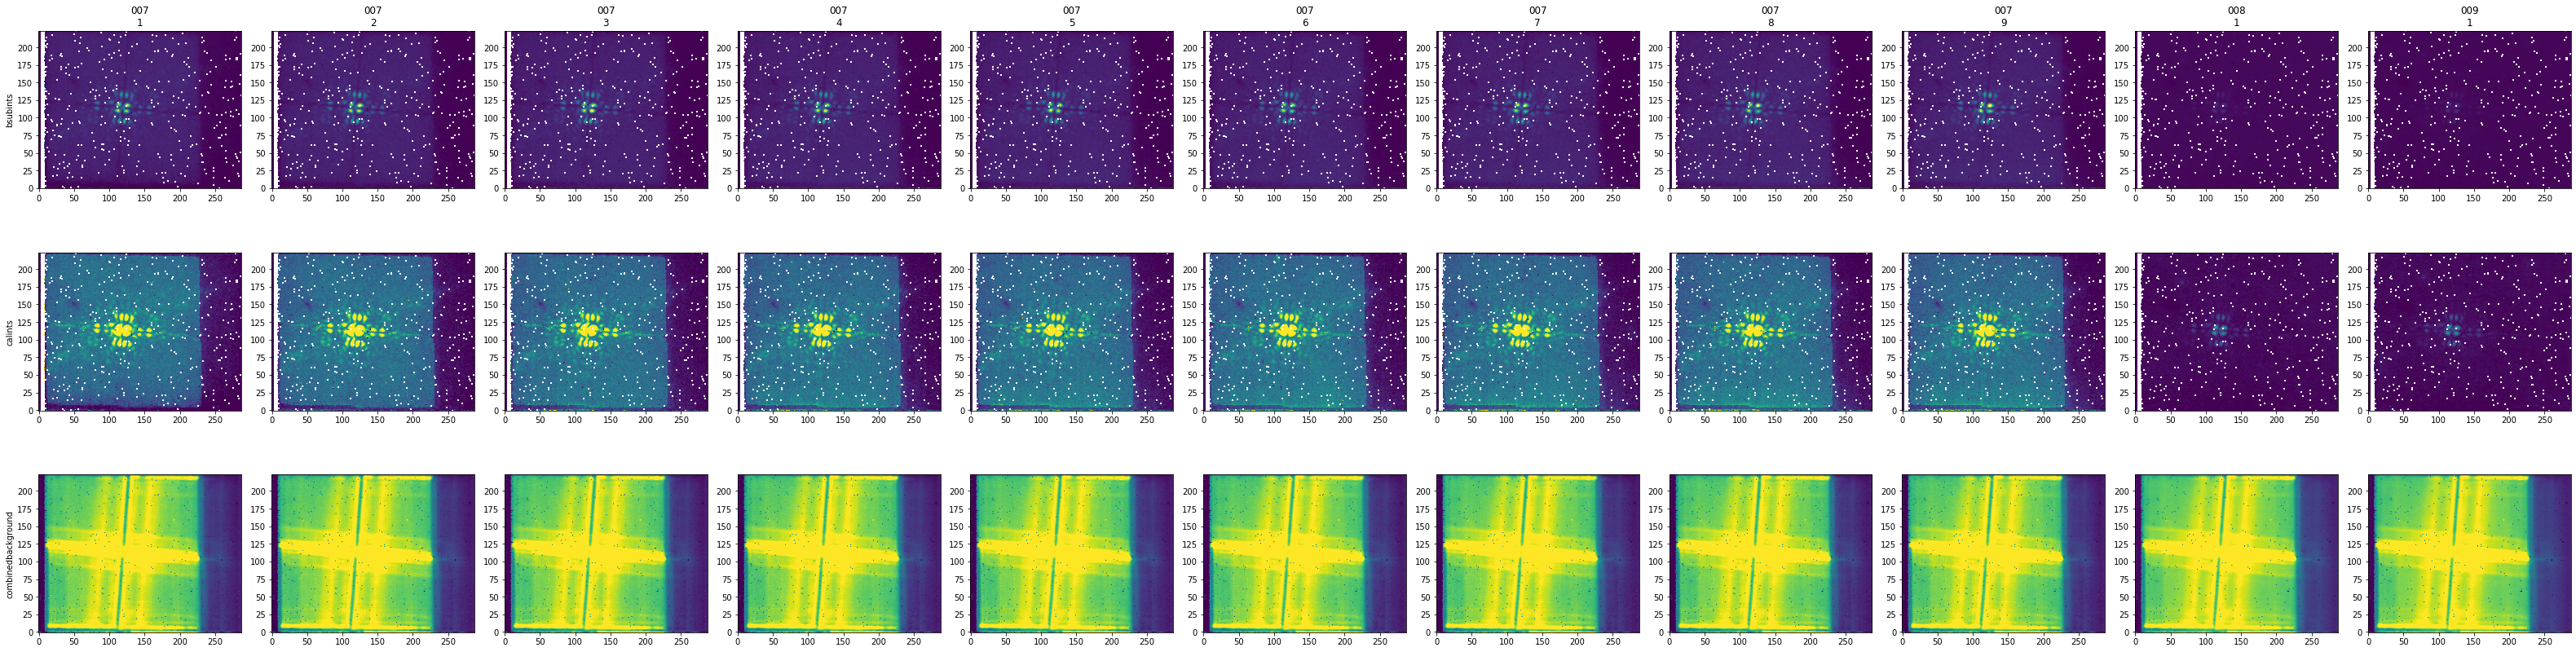

In [25]:
stems = all_results['stem'].unique()
ftypes = all_results['ftype'].unique()

nrows = ftypes.size
ncols = stems.size
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))


for i, (stem, ind) in enumerate(gb.groups.items()):
    # use the filetype to index the results
    group = all_results.loc[ind, ['ftype', 'img']].copy().set_index('ftype')
    ax_col = axes[:, i]
    title = '\n'.join([fits.getval(all_results.loc[ind[0], 'filepath'], k, 0) for k in ['OBSERVTN', 'EXPOSURE']])
    ax_col[0].set_title(title)#[7:10] + ' ' + stem[-20:-18])
    
    imgs = group.loc[ftypes, 'img']
    vmin, vmax = np.nanquantile(np.stack(imgs), [0.05, 0.95])
    
    for j, ftype in enumerate(ftypes):
        img = imgs[ftype]
        imax = ax_col[j].imshow(img, vmin=vmin, vmax=vmax)
    
# label the rows
for i, ftype in enumerate(ftypes):        
    ax = axes[i, 0]
    ax.set_ylabel(ftype)

fig.tight_layout()